<a href="https://colab.research.google.com/github/ArunK-ML/Project---Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [1]:
!pip install tensorflow>=2.9.0 scikit-learn matplotlib pillow streamlit numpy

# **Data Load**

# **Data View**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and preprocessing for training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Define data preprocessing for validation and test images
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(TRAIN_DIR,
                                              target_size=(150, 150), # Adjust target size as needed
                                              batch_size=32,
                                              class_mode='categorical')

valid_gen = valid_test_datagen.flow_from_directory(VALID_DIR,
                                                   target_size=(150, 150), # Adjust target size as needed
                                                   batch_size=32,
                                                   class_mode='categorical')

test_gen = valid_test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(150, 150), # Adjust target size as needed
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [8]:
# ========================================
# STEP 1: Import libraries
# ========================================
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
# ========================================
# STEP 2: Mount Google Drive
# ========================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ========================================
# STEP 3: Set dataset paths
# (update if your path is different)
# ========================================
DATASET_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour"
TRAIN_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train"
TEST_DIR  = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/test"
VALID_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/valid"


In [4]:
import os

for split in ["train", "valid", "test"]:
    folder = os.path.join(DATASET_DIR, split)
    print(f"\n--- {split.upper()} ---")
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            print(f"{cls:15s} -> {len(os.listdir(cls_path))} images")



--- TRAIN ---
no_tumor        -> 335 images
pituitary       -> 438 images
meningioma      -> 358 images
glioma          -> 564 images

--- VALID ---
glioma          -> 161 images
no_tumor        -> 99 images
meningioma      -> 124 images
pituitary       -> 118 images

--- TEST ---
pituitary       -> 54 images
no_tumor        -> 49 images
glioma          -> 80 images
meningioma      -> 63 images


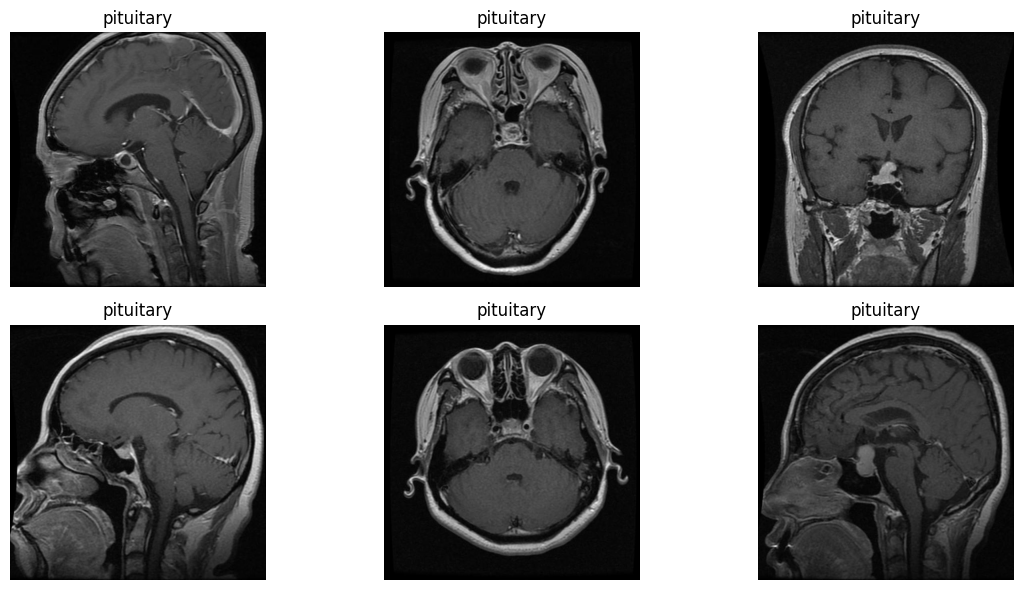

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

SPLIT = "train"  # change to "valid" or "test"
CLASS = random.choice(os.listdir(os.path.join(DATASET_DIR, SPLIT)))
IMG_DIR = os.path.join(DATASET_DIR, SPLIT, CLASS)

images = random.sample(os.listdir(IMG_DIR), 6)  # pick 6 random images

plt.figure(figsize=(12,6))
for i, img_name in enumerate(images):
    img_path = os.path.join(IMG_DIR, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(CLASS)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
# ========================================
# STEP 4: Data Generators (with Augmentation)
# ========================================

# Define image size and batch size
IMG_SIZE = (224, 224) # You can adjust this as needed
BATCH_SIZE = 32 # You can adjust this as needed

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.8,1.2)
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_gen = test_val_datagen.flow_from_directory(
    VALID_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

class_indices = train_gen.class_indices
print("Class indices:", class_indices)

# Save class mapping
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


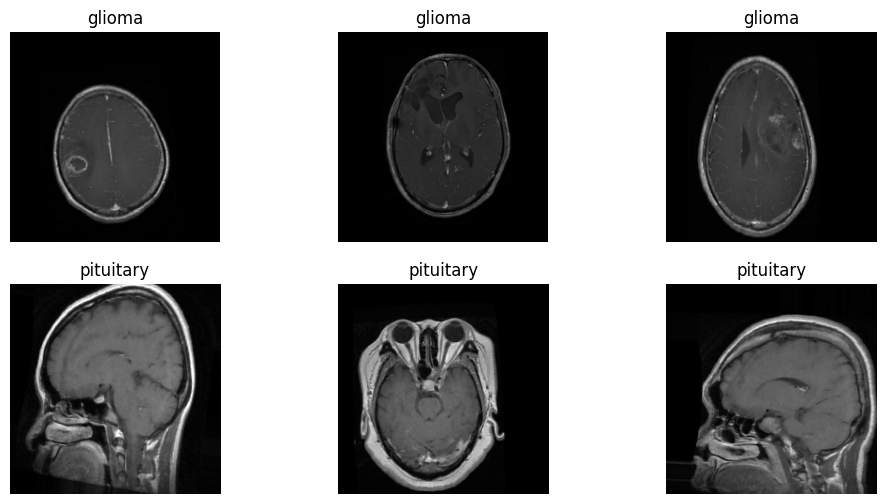

In [11]:
# ========================================
# STEP 5: Visualize Sample Images
# ========================================
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    label = list(train_gen.class_indices.keys())[y_batch[i].argmax()]
    plt.title(label)
    plt.axis("off")
plt.show()


In [12]:
# ========================================
# STEP 6: Build Custom CNN
# ========================================
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="custom_cnn")
    return model

num_classes = train_gen.num_classes
custom_model = build_custom_cnn(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
custom_model.summary()


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,684 (436.27 KB)

 Trainable params: 110,980 (433.52 KB)

 Non-trainable params: 704 (2.75 KB)